In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import cv2

In [3]:
root_dir = '/kaggle/input/hubmap-hacking-the-human-vasculature/'
train_dir = root_dir+'train/'
tile_meta_file = 'tile_meta.csv'
polygons_file = 'polygons.jsonl'

# tile_meta.csv info

df = pd.read_csv(root_dir+tile_meta_file)
print(df.head(),'\n')
print('Value counts per dataset:\n', df['dataset'].value_counts())

             id  source_wsi  dataset      i      j
0  0006ff2aa7cd           2        2  16896  16420
1  000e79e206b7           6        3  10240  29184
2  00168d1b7522           2        2  14848  14884
3  00176a88fdb0           7        3  14848  25088
4  0033bbc76b6b           1        1  10240  43008 

Value counts per dataset:
 3    5400
2    1211
1     422
Name: dataset, dtype: int64


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [69]:
class HuBMAP(Dataset):
    def __init__(self, root_dir, polygons_file, tsfm=None) -> None:
        self.df = pd.read_json(root_dir+polygons_file, lines=True)
        self.train_dir = root_dir+'train/'
        self.tsfm = tsfm
        self.targets = {'blood_vessel': [1, 0, 0], 'glomerulus': [0, 1, 0], 'unsure': [0, 0, 1]}

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> tuple:
        sample_id = self.df['id'].iloc[idx]
        img = Image.open(self.train_dir + f'{sample_id}.tif')
        
        sample = self.df['annotations'].iloc[idx][0]
        sample_coords = np.array(sample['coordinates'][0]).T
        
        mask = self.generate_mask(sample_coords, (512, 512, 3))
        if self.tsfm is not None:
            img = self.tsfm(img)
        mask = self.tsfm(mask)

        return img.to(device), mask.to(device)
    
    def generate_mask(self, sample_coords: np.array, mask_img_shape: tuple):
        row_mask = sample_coords[1]
        col_mask = sample_coords[0]
        
        mask = np.zeros((512, 512, 3), np.uint8)
        pts = np.array([[x,y] for(x,y) in sample_coords.T])
        cv2.drawContours(mask, [pts],-1, (0, 255, 0), -1)
        
        mask = mask[:, :, 1]
        # cv2.polylines(mask, [pts], isClosed=True, color=(255, 0, 0), thickness=2)
        return mask

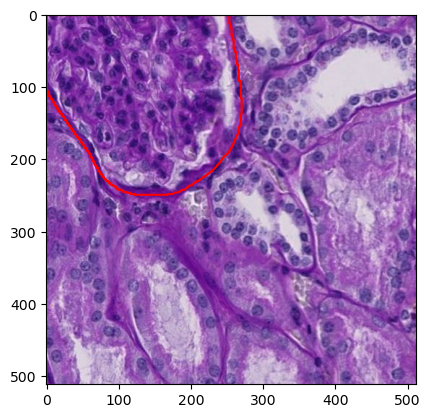

In [6]:
df = pd.read_json(root_dir+polygons_file, lines=True)
first_samp = df['annotations'].iloc[0][0]
first_samp_id = df['id'].iloc[0]

img = Image.open(train_dir+f'{first_samp_id}.tif')
img_np = np.array(img)

first_samp_coords = np.array(first_samp['coordinates'][0]).T

plt.figure()
plt.imshow(img_np)
plt.plot(first_samp_coords[0], first_samp_coords[1], 'r')
plt.show()

In [71]:
import torch.nn as nn
import torch.functional as F
import torch

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sz=4, stride=2, padding=1, normalise=True):
        super().__init__()
        self.normalise = normalise

        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_sz, stride, padding)
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.leaky_relu(x)
        x = self.conv(x)

        if self.normalise:
            x = self.batch_norm(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sz=4, stride=2, padding=1, use_dropout=False):
        super().__init__()
        self.use_dropout = use_dropout

        self.relu = nn.ReLU(inplace=True)
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_sz, stride, padding)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=0.5, inplace=True)

    def forward(self, x):
        x = self.relu(x)
        x = self.conv_transpose(x)
        x = self.batch_norm(x)

        if self.use_dropout:
            x = self.dropout(x)
        return x


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        self.encoder5 = EncoderBlock(512, 512)
        self.encoder6 = EncoderBlock(512, 512)
        #self.encoder7 = EncoderBlock(512, 512)
        self.encoder7 = EncoderBlock(512, 512, normalise=False)

        self.decoder7 = DecoderBlock(512, 512, use_dropout=True)
        # self.decoder7 = DecoderBlock(2*512, 512, use_dropout=True)
        self.decoder6 = DecoderBlock(2*512, 512, use_dropout=True)
        self.decoder5 = DecoderBlock(2*512, 512)
        self.decoder4 = DecoderBlock(2*512, 256)
        self.decoder3 = DecoderBlock(2*256, 128)
        self.decoder2 = DecoderBlock(2*128, 64)
        self.decoder1 = nn.ConvTranspose2d(2*64, 1, kernel_size=4, stride=2, padding=1)
        
        self.softmax = nn.Softmax(dim=3)

    def forward(self, x):
        # encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        e7 = self.encoder7(e6)
        # e8 = self.encoder8(e7)

        # decoder with skipping connections
        # d8 = self.decoder8(e8)
        # d8 = torch.cat([d8, e7], dim=1)

        d7 = self.decoder7(e7)
        d7 = torch.cat([d7, e6], dim=1)

        d6 = self.decoder6(d7)
        d6 = torch.cat([d6, e5], dim=1)

        d5 = self.decoder5(d6)
        d5 = torch.cat([d5, e4], dim=1)

        d4 = self.decoder4(d5)
        d4 = torch.cat([d4, e3], dim=1)

        d3 = self.decoder3(d4)
        d3 = torch.cat([d3, e2], dim=1)

        d2 = self.decoder2(d3)
        d2 = torch.cat([d2, e1], dim=1)

        d1 = self.decoder1(d2)
        return d1

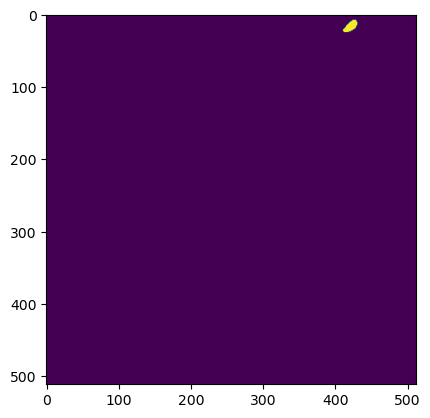

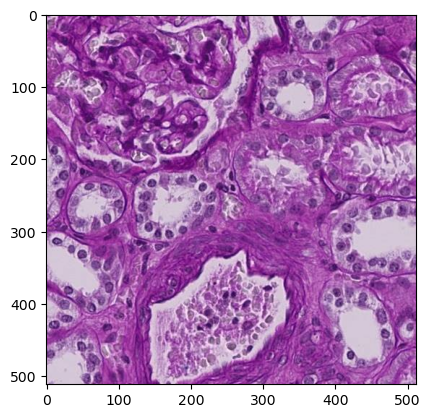

In [70]:
batch_size_train = 32
batch_size_test = 16
# standard torchvision normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
# tsfms = transforms.Compose([transforms.ToTensor(), normalize])
tsfms = transforms.Compose([transforms.ToTensor()])
dataset = HuBMAP(root_dir, polygons_file, tsfm=tsfms)

train_sz = int(0.8 * len(dataset))
test_sz = len(dataset) - train_sz
train_data, test_data = torch.utils.data.random_split(dataset, [train_sz, test_sz])

train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)


img, mask = train_data.__getitem__(0)
mask = transforms.ToPILImage()(mask)
img = transforms.ToPILImage()(img)

plt.figure()
plt.imshow(mask)
plt.show()

plt.figure()
plt.imshow(img)
plt.show()

In [72]:
import gc

epochs = 10

model = UNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(model.parameters(), betas=(0.5, 0.999))

for epoch in range(epochs):
    avg_train_loss = 0
    
    for batch_idx, (x, mask) in enumerate(train_loader):
        model.train()
        
        pred = model(x)
        loss = criterion(pred, mask)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        avg_train_loss += loss.cpu().detach()
        torch.cuda.empty_cache() 
        gc.collect()
        
    avg_val_loss = 0
    for batch_idx, (x, mask) in enumerate(test_loader):
        model.eval()
        pred = model(x)
        loss = criterion(pred, mask)

        avg_val_loss += loss
        break  # cuda OOM??
        
    print(f'Epoch nr. {epoch + 1:02d}/{epochs} --- Training loss: {avg_train_loss/len(train_loader):.4f} --- Validation loss: {avg_val_loss:.4f}')

Epoch nr. 01/10 --- Training loss: 0.2727 --- Validation loss: 0.1527
Epoch nr. 02/10 --- Training loss: 0.0948 --- Validation loss: 1.1094
Epoch nr. 03/10 --- Training loss: 0.0922 --- Validation loss: 75.2800
Epoch nr. 04/10 --- Training loss: 0.0914 --- Validation loss: 0.1066
Epoch nr. 05/10 --- Training loss: 0.0859 --- Validation loss: 0.1850
Epoch nr. 06/10 --- Training loss: 0.0839 --- Validation loss: 0.5310
Epoch nr. 07/10 --- Training loss: 0.0798 --- Validation loss: 0.0376
Epoch nr. 08/10 --- Training loss: 0.0802 --- Validation loss: 0.0918
Epoch nr. 09/10 --- Training loss: 0.0797 --- Validation loss: 0.0994
Epoch nr. 10/10 --- Training loss: 0.0774 --- Validation loss: 0.0270


In [76]:
avg_val_loss = 0
for batch_idx, (x, mask) in enumerate(test_loader):
    model.eval()
    pred = model(x)
    loss = criterion(pred, mask)

    avg_val_loss += loss
    break  # cuda OOM??
print(f'Validation loss: {avg_val_loss}')

Validation loss: 0.09005717188119888


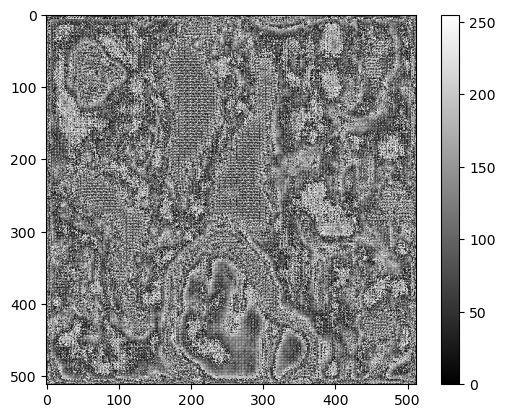

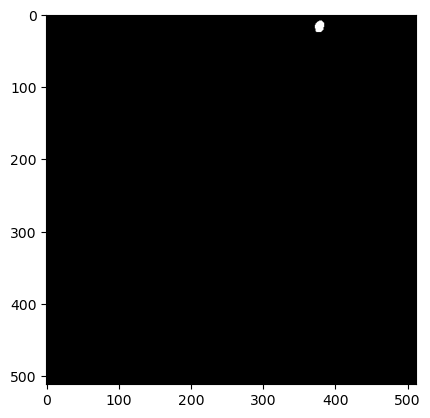

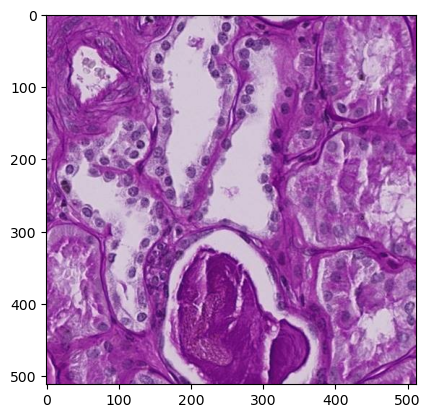

In [77]:
mask_all = pred[0].cpu().detach()
'''mask_r = pred[0][0].cpu().detach().numpy()
mask_g = pred[0][1].cpu().detach().numpy()
mask_b = pred[0][2].cpu().detach().numpy()'''

mask_t = transforms.ToPILImage()(mask[0])
#mask_pred = transforms.ToPILImage()(mask_r[0])
x_t = transforms.ToPILImage()(x[0])
mask_all = transforms.ToPILImage()(mask_all)

plt.figure()
plt.imshow(mask_all, cmap='gray')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(mask_t, cmap='gray')
plt.show()

plt.figure()
plt.imshow(x_t)
plt.show()